# Proyecto: Engrasandonos las manos con datos

¡Bienvenidos al segundo proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es continuar con la limpieza de datos y avanzar en remover valores faltantes y remover outliers. Por otro lado, vamos a agregar nuevos atributos basados en los datos.

## Dataset: Propiedades en venta en Ciudad de Buenos Aires.

En este proyecto, trabajaremos con una muestra del conjunto de datos de propiedades en venta mencionado. En este dataset, cada fila es una propiedad en venta. A continuación vamos a describir los atributos que consideramos en esta muestra:

* id: id de la propiedad
* created_on: fecha en la que la propiedad ingresó al sitio
* operation: alquiler (rent) o venta (sell)
* property_type: tipo de propiedad (casa, departamento, ph, etcétera)
* place_with_parent_names: nombre del lugar donde se encuentra la propiedad según el publicador
* lat-lon: coordenadas concatenadas
* lat: latitud
* lon: longitud
* price: precio en la moneda especificada en currency
* currency: divisa en la que está expresada la publicación
* price_aprox_usd: precio aproximado en dólares estadounidenses
* surface_total_in_m2: superficie total (en metros cuadrados)
* surface_covered_in_m2: superficie cubierta (en metros cuadrados)
* price_usd_per_m2: precio por metro cuadrado en dólares (precio dólares / superficie)
* floor: número de piso (si corresponde)
* rooms: cantidad de ambientes
* expenses: expensas (si corresponde)
* barrio: barrio según cartografía oficial
* properati_url: url de la publicación en Properati

A continuación vamos a levantar el dataset para comenzar el procesamiento. Cabe destacar que en este caso ya fueron hechas las correcciones de coordenadas y superficies incorrectas que vimos en el proyecto anterior

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer


MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

plt.rcParams['figure.figsize'] = (12,5)

In [2]:
path_dataset = 'dataset/datos_properati_limpios.csv'
df = pd.read_csv(path_dataset, parse_dates=['created_on'])

In [3]:
df.columns

Index(['created_on', 'property_type', 'place_name', 'place_with_parent_names',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses', 'properati_url', 'barrio'],
      dtype='object')

In [4]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 13756 observaciones


Dado que ya lo trabajamos en el proyecto anterior, en este caso ya hemos filtrado observaciones para trabajar solo con casas (house), departamentos (apartment) y PH (PH).

### Outliers

Analicemos en primer lugar los valores extremos que puede haber en los precios y en las superficies. Esto nos va a ser útil para luego imputar usando medidas de tendencia central, como el promedio. 
Recordemos que las medidas de tendencia central pueden ser sensibles a outliers, por lo que la imputación de valores faltantes puede verse afectada

Una posible pregunta que surge es si conviene primero imputar faltantes y luego remover outliers, o lo contrario.  Cuando se imputa se modifica la distribución de los datos. Por eso, las cotas que utilicemos para definir los outliers se verán afectadas por este cambio y modificarán los resultados finales. Entonces comenzaremos quitando outliers.

Vamos a trabajar con `price_usd_per_m2`. Precios altos pueden corresponderse con grandes superficies, por lo que conviene analizar juntos ambos atributos. Veamos la distribución de los valores y un boxplot para comenzar a identificar los outliers.

**1) Utilizá** seaborn para hacer un `distplot` del precio por metro cuadrado. 

Deberás hacer un `drop` de los valores `NaN` de esta columna antes de graficar.

In [5]:
columns = ['price_usd_per_m2']
df.dropna(subset=columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12973 entries, 0 to 13755
Data columns (total 15 columns):
created_on                 12973 non-null datetime64[ns]
property_type              12973 non-null object
place_name                 12973 non-null object
place_with_parent_names    12973 non-null object
lat                        12973 non-null float64
lon                        12973 non-null float64
price_aprox_usd            12973 non-null float64
surface_total_in_m2        12973 non-null float64
surface_covered_in_m2      12476 non-null float64
price_usd_per_m2           12973 non-null float64
floor                      1880 non-null float64
rooms                      10733 non-null float64
expenses                   3357 non-null float64
properati_url              12973 non-null object
barrio                     12973 non-null object
dtypes: datetime64[ns](1), float64(9), object(5)
memory usage: 1.6+ MB


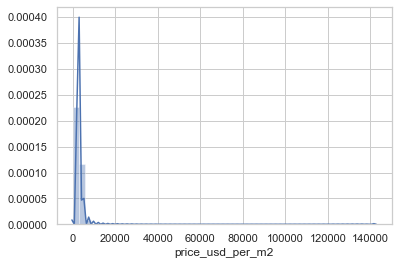

In [6]:
sns.set(style="whitegrid")
x= df.price_usd_per_m2
ax = sns.distplot(x)

**2) Hacé** un `boxplot` de la columna `price_usd_per_m2`

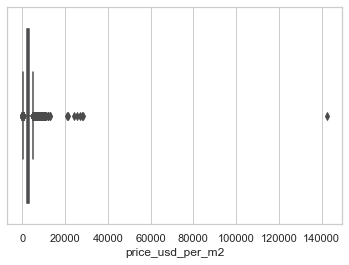

In [7]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["price_usd_per_m2"])

¿A qué conclusión podemos llegar observando estas figuras?
**Responder**

Existen valores atipicos(outliers), que afectan en gran manera la distribucion y el boxplot, por ende estos valores podrian ser removidos para validar de mejor manera el comportamiento de la muestra

Para confirmar la presencia de outliers vamos a utilizar los percentiles.

**3) Describir** la columna mostrando sus estadísticos

In [8]:
df.price_usd_per_m2.describe()

count     12973.000000
mean       2695.065767
std        1773.086831
min           0.958333
25%        1959.183673
50%        2510.204082
75%        3125.000000
max      142450.141026
Name: price_usd_per_m2, dtype: float64

Estamos ante la presencia de valores extremos en ambas puntas de la distribución. Vamos a aplicar la técnica del rango intercuartílico para limpiarlos.

Para obtener el rango tenemos que calcular la diferencia entre el tercer y el primer percentil. Luego en base a esto calcularemos los valores mínimos y máximos para definir qué observaciones serán descartadas.

**4) Aplicar la técnica del rango intercuartílico** para limpiar el precio por metro cuadrado. El resultado deberá ser un `dataframe` llamado `df_filtered` sin los outliers.

In [9]:
primer_cuartil = df["price_usd_per_m2"].quantile(0.25)
print(primer_cuartil)

1959.1836734693882


In [10]:
tercer_cuartil = df["price_usd_per_m2"].quantile(0.75)
print(tercer_cuartil)

3125.0


In [11]:
iqr = df["price_usd_per_m2"].quantile(0.75) - df["price_usd_per_m2"].quantile(0.25)
print(iqr)
iqr = iqr * 1.5
print(iqr)
atipicoInf = primer_cuartil - iqr
atipicoSup = tercer_cuartil + iqr
print(atipicoInf)
print(atipicoSup)

1165.8163265306118
1748.7244897959176
210.45918367347053
4873.724489795917


In [12]:
# Realizar el filtrado intercuartílico en esta celda
p1 = np.percentile(df.price_usd_per_m2, 1)
print(p1)
p99 = np.percentile(df.price_usd_per_m2, 99)
print(p99)

df_filtered = df[(df.price_usd_per_m2 >= atipicoInf) & (df.price_usd_per_m2 <= atipicoSup)]

681.101052631579
6794.992175273877


**5)** Volver a **plotear** con `distplot` y `boxplot` los precios sin los outliers y observá las diferencias con los anteriores ploteo.

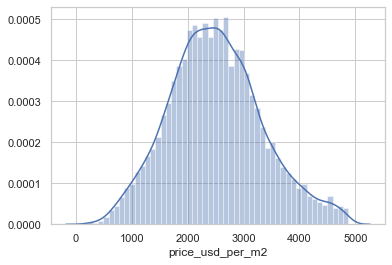

In [13]:
x= df_filtered.price_usd_per_m2
ax = sns.distplot(x)

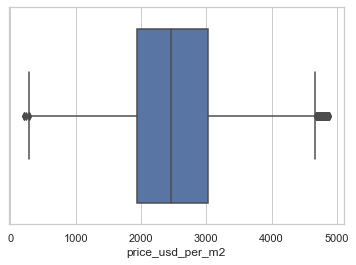

In [14]:
ax = sns.boxplot(x=df_filtered["price_usd_per_m2"])

**6) Describir** nuevamente la columna mostrando sus estadísticos.

In [15]:
df_filtered.price_usd_per_m2.describe()

count    12288.000000
mean      2505.089766
std        834.949633
min        213.068182
25%       1933.333333
50%       2466.666667
75%       3027.864583
max       4871.794872
Name: price_usd_per_m2, dtype: float64

Vamos a seguir trabajando con el `dataframe` filtrado

In [16]:
df = df_filtered

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 1 to 13755
Data columns (total 15 columns):
created_on                 12288 non-null datetime64[ns]
property_type              12288 non-null object
place_name                 12288 non-null object
place_with_parent_names    12288 non-null object
lat                        12288 non-null float64
lon                        12288 non-null float64
price_aprox_usd            12288 non-null float64
surface_total_in_m2        12288 non-null float64
surface_covered_in_m2      11814 non-null float64
price_usd_per_m2           12288 non-null float64
floor                      1833 non-null float64
rooms                      10128 non-null float64
expenses                   3198 non-null float64
properati_url              12288 non-null object
barrio                     12288 non-null object
dtypes: datetime64[ns](1), float64(9), object(5)
memory usage: 1.5+ MB


### Valores Faltantes

A diferencia del proyecto pasado, vamos a intentar imputar los valores faltantes para los atributos que consideramos importantes para el mercado inmobiliario. 

Estos atributos son los que informan **superficie (total o cubierta), cantidad de ambientes, precio y precio por metro cuadrado**. 

Veamos en primer lugar cuántos valores faltantes tiene cada atributo. Nos interesa verlo como un porcentaje en relación a la cantidad de observaciones. Si un atributo tiene un elevado porcentaje de faltantes, puede ser mejor no considerarlo en el análisis.

**7) Mostrar** cual es el porcentaje de valores faltantes para cada columna.

In [18]:
main_columns = ['surface_total_in_m2','surface_covered_in_m2','price_aprox_usd', 'price_usd_per_m2', 'rooms', 'floor', 'expenses']
texto = ''
porce = 0
for item in main_columns:
        valor = sum(pd.isnull(df[item]))
        porce = (valor / df.shape[0])*100
        texto = texto +  item + ': total filas:'+ str(df.shape[0]) + ' nulos: ' + str(valor) + ' porcentaje: ' + str(porce) +  '\n'

print(texto)

surface_total_in_m2: total filas:12288 nulos: 0 porcentaje: 0.0
surface_covered_in_m2: total filas:12288 nulos: 474 porcentaje: 3.857421875
price_aprox_usd: total filas:12288 nulos: 0 porcentaje: 0.0
price_usd_per_m2: total filas:12288 nulos: 0 porcentaje: 0.0
rooms: total filas:12288 nulos: 2160 porcentaje: 17.578125
floor: total filas:12288 nulos: 10455 porcentaje: 85.0830078125
expenses: total filas:12288 nulos: 9090 porcentaje: 73.974609375



Podemos ver en los resultados que los atributos `floor` y `expenses` tienen un elevado porcentaje de faltantes.  Una opción sería descartar estas columnas en el análisis. 
Si elimináramos las observaciones (filas) asociadas a estos, perderíamos el 84.79% de los datos, mermando demasiado el conjunto de datos.

Otra opción sería por ejemplo considerar categorías como faltantes o no faltantes o en todo caso analizar si hay algún patrón para poder evitar quitarlos. 

Para avanzar con el proyecto, vamos a quitar esos atributos.

In [19]:
df = df.drop(['floor', 'expenses'], axis = 1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 1 to 13755
Data columns (total 13 columns):
created_on                 12288 non-null datetime64[ns]
property_type              12288 non-null object
place_name                 12288 non-null object
place_with_parent_names    12288 non-null object
lat                        12288 non-null float64
lon                        12288 non-null float64
price_aprox_usd            12288 non-null float64
surface_total_in_m2        12288 non-null float64
surface_covered_in_m2      11814 non-null float64
price_usd_per_m2           12288 non-null float64
rooms                      10128 non-null float64
properati_url              12288 non-null object
barrio                     12288 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.3+ MB


Analicemos estrategias para imputar los valores faltantes para los atributos `rooms`, `surface_total_in_m2` y `surface_covered_in_m2`.

Como vimos en las actividades, entre las opciones que tenemos está la posibilidad de imputar por algún medida de tendencia central, como el caso de la media o la mediana. Vamos a avanzar en esa dirección.

**8) Imputar las observaciones faltantes** de la columna `surface_total_in_m2 ` y `surface_covered_in_m2` usando la **media**. 

`Scikit-learn` nos provee la clase `Imputer` que implementa las formas más comunes de imputación.

Una de las limitaciones que presenta este tipo de imputación es que provoca estimaciones sesgadas de la varianza. Esto impacta en los errores estandar y, por ende, en los tests estadístcos.

Este tipo de técnicas es útil cuando los valores son completamente al azar.

In [21]:
imp = SimpleImputer(strategy='mean')
surface = df.surface_covered_in_m2.values
imp.fit(surface.reshape(-1,1))
print(surface)
surface_imputed = imp.transform(surface.reshape(-1,1))
df.surface_covered_in_m2 = surface_imputed
df.info()

[120.  48.  70. ...  82.  45.  58.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 1 to 13755
Data columns (total 13 columns):
created_on                 12288 non-null datetime64[ns]
property_type              12288 non-null object
place_name                 12288 non-null object
place_with_parent_names    12288 non-null object
lat                        12288 non-null float64
lon                        12288 non-null float64
price_aprox_usd            12288 non-null float64
surface_total_in_m2        12288 non-null float64
surface_covered_in_m2      12288 non-null float64
price_usd_per_m2           12288 non-null float64
rooms                      10128 non-null float64
properati_url              12288 non-null object
barrio                     12288 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.3+ MB


In [22]:
imp = SimpleImputer(strategy='mean')
surface = df.surface_total_in_m2.values
imp.fit(surface.reshape(-1,1))
print(surface)
surface_imputed = imp.transform(surface.reshape(-1,1))
df.surface_total_in_m2 = surface_imputed
df.info()

[130.  52.  70. ... 115.  45.  60.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 1 to 13755
Data columns (total 13 columns):
created_on                 12288 non-null datetime64[ns]
property_type              12288 non-null object
place_name                 12288 non-null object
place_with_parent_names    12288 non-null object
lat                        12288 non-null float64
lon                        12288 non-null float64
price_aprox_usd            12288 non-null float64
surface_total_in_m2        12288 non-null float64
surface_covered_in_m2      12288 non-null float64
price_usd_per_m2           12288 non-null float64
rooms                      10128 non-null float64
properati_url              12288 non-null object
barrio                     12288 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.3+ MB


**9) Imputar las observaciones faltantes** de la columna `rooms` usando la **mediana**.

In [23]:
imp = SimpleImputer(strategy='median')
surface = df.rooms.values
imp.fit(surface.reshape(-1,1))
print(surface)
surface_imputed = imp.transform(surface.reshape(-1,1))
df.rooms = surface_imputed
df.info()

[ 4.  1. nan ...  3.  3.  3.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 1 to 13755
Data columns (total 13 columns):
created_on                 12288 non-null datetime64[ns]
property_type              12288 non-null object
place_name                 12288 non-null object
place_with_parent_names    12288 non-null object
lat                        12288 non-null float64
lon                        12288 non-null float64
price_aprox_usd            12288 non-null float64
surface_total_in_m2        12288 non-null float64
surface_covered_in_m2      12288 non-null float64
price_usd_per_m2           12288 non-null float64
rooms                      12288 non-null float64
properati_url              12288 non-null object
barrio                     12288 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.3+ MB


### Variables binarias

#### Generar variables binarias para el atributo `property_type`.

Hay que tener en cuenta en este caso que el atributo es categórico.

Para hacerlo usando scikit-learn, por como vienen dados los valores (en formato string), primero conviene convertirlos en numéricos. Para esto usamos `LabelEncoder`.

**10) Convertí** las variables de `property_type` utilizando `LabelEncoder`

In [24]:
categorical_feature_mask = df.dtypes==object
categorical_cols = df.columns[categorical_feature_mask].tolist()
print(categorical_cols)
cat_cols = categorical_cols[:1]
print(cat_cols)

['property_type', 'place_name', 'place_with_parent_names', 'properati_url', 'barrio']
['property_type']


In [25]:
le = LabelEncoder()
df['property_type']= le.fit_transform(df['property_type']) 
df['property_type'].unique() 

array([1, 2, 0], dtype=int64)

In [26]:
#df[cat_cols] = df[cat_cols].apply(lambda col: le.fit_transform(col))
#df[cat_cols].head(10)

In [27]:
df

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio
1,2017-08-29,1,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.00,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO
2,2017-08-29,1,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.00,52.0,48.0,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO
3,2017-08-29,1,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.00,70.0,70.0,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO
4,2017-08-30,2,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO
5,2017-08-30,2,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,2017-12-17,1,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668970,-58.443897,49000.00,75.0,75.0,653.333333,4.0,https://www.properati.com.ar/1j22x_venta_depar...,VILLA SOLDATI
13752,2018-01-08,1,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668741,-58.443146,60000.00,55.0,55.0,1090.909091,3.0,https://www.properati.com.ar/1jcpm_venta_depar...,VILLA SOLDATI
13753,2018-01-23,2,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.664170,-58.443317,99000.00,115.0,82.0,860.869565,3.0,https://www.properati.com.ar/1k1hs_venta_casa_...,VILLA SOLDATI
13754,2018-01-27,1,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.665005,-58.443041,50433.01,45.0,45.0,1120.733556,3.0,https://www.properati.com.ar/1k5v0_venta_depar...,VILLA SOLDATI


**11) Mostrar** las clases del `LabelEncoder`:

In [28]:
# Mostrar la propiedad classes_ del LabelEncoder que creaste
list(le.classes_)

['PH', 'apartment', 'house']

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288 entries, 1 to 13755
Data columns (total 13 columns):
created_on                 12288 non-null datetime64[ns]
property_type              12288 non-null int32
place_name                 12288 non-null object
place_with_parent_names    12288 non-null object
lat                        12288 non-null float64
lon                        12288 non-null float64
price_aprox_usd            12288 non-null float64
surface_total_in_m2        12288 non-null float64
surface_covered_in_m2      12288 non-null float64
price_usd_per_m2           12288 non-null float64
rooms                      12288 non-null float64
properati_url              12288 non-null object
barrio                     12288 non-null object
dtypes: datetime64[ns](1), float64(7), int32(1), object(4)
memory usage: 1.3+ MB


In [30]:
df

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio
1,2017-08-29,1,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.00,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO
2,2017-08-29,1,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.00,52.0,48.0,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO
3,2017-08-29,1,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.00,70.0,70.0,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO
4,2017-08-30,2,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO
5,2017-08-30,2,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,2017-12-17,1,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668970,-58.443897,49000.00,75.0,75.0,653.333333,4.0,https://www.properati.com.ar/1j22x_venta_depar...,VILLA SOLDATI
13752,2018-01-08,1,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668741,-58.443146,60000.00,55.0,55.0,1090.909091,3.0,https://www.properati.com.ar/1jcpm_venta_depar...,VILLA SOLDATI
13753,2018-01-23,2,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.664170,-58.443317,99000.00,115.0,82.0,860.869565,3.0,https://www.properati.com.ar/1k1hs_venta_casa_...,VILLA SOLDATI
13754,2018-01-27,1,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.665005,-58.443041,50433.01,45.0,45.0,1120.733556,3.0,https://www.properati.com.ar/1k5v0_venta_depar...,VILLA SOLDATI


Luego con `OneHotEncoder` obtenemos las categorías expresadas como **variables binarias**. 

**12) Aplicar** `OneHotEncoder` sobre las variables categóricas para crear un dataframe `categoricals_df`

Aplicando label encoder

In [31]:
le = LabelEncoder()
#categoricals_le = 
#print(cat_cols)
nombre_col = (lambda item, x: str(item) + str(x))
for item in categorical_cols[:]:
    if (item != 'properati_url'): 
        df[item]= le.fit_transform(df[item]) 
print(categorical_cols)
print(df)

['property_type', 'place_name', 'place_with_parent_names', 'properati_url', 'barrio']
      created_on  property_type  place_name  place_with_parent_names  \
1     2017-08-29              1          31                       36   
2     2017-08-29              1          31                       36   
3     2017-08-29              1          31                       36   
4     2017-08-30              2          33                       38   
5     2017-08-30              2          31                       36   
...          ...            ...         ...                      ...   
13751 2017-12-17              1          68                       68   
13752 2018-01-08              1          68                       68   
13753 2018-01-23              2          68                       68   
13754 2018-01-27              1          68                       68   
13755 2018-01-27              1          61                       61   

             lat        lon  price_aprox_usd  sur

Ya se aplicó el **LabelEncoder**,  
A continuacion se aplicará **OneHotEncoder**. 
En la siguiente celda se construira una columna por cada valor diferente de cada columna, es asi como hay columnas Ejemplo property_type la cual tendra otras 3 homonimas concatenadas a un indice( property_type0, property_type1, property_type2)  en el dataframe, no se suprimio la columna property_type, de igual manera se hizo para todas las variables categoricas, para place_name se obtuvo 71 columnas adicionales, barrio 48 nuevas columnas y por la misma razon se filtro a properati_url dado que añadia tantas columnas como valores diferntes tenia, mas de 12mil

In [32]:
oh = OneHotEncoder(sparse=False)
#categoricals_df = oh.fit_transform(df).toarray() 
nombre_col = (lambda item, x: str(item) + str(x))
for item in categorical_cols[:]:
    if (item != 'properati_url'): 
        print(item)
        item_values = df[item].values.reshape(-1,1)
        #data['Geography']= le.fit_transform(data['Geography']) 
        #print(item_values)
        oh.fit(item_values)
        categoricals_df = oh.transform(item_values)
        print(categoricals_df)
        columnas = categoricals_df.shape[1]
        print(columnas)
        for x in range(columnas):
            df[nombre_col(item, x)] = categoricals_df[:, x]

property_type
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
3
place_name
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
71
place_with_parent_names
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
71
barrio
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
48


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [33]:
df

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio,property_type0,property_type1,property_type2,place_name0,place_name1,place_name2,place_name3,place_name4,place_name5,place_name6,place_name7,place_name8,place_name9,place_name10,place_name11,place_name12,place_name13,place_name14,place_name15,place_name16,place_name17,place_name18,place_name19,place_name20,place_name21,place_name22,place_name23,place_name24,place_name25,place_name26,place_name27,place_name28,place_name29,place_name30,place_name31,place_name32,place_name33,place_name34,place_name35,place_name36,place_name37,place_name38,place_name39,place_name40,place_name41,place_name42,place_name43,place_name44,place_name45,place_name46,place_name47,place_name48,place_name49,place_name50,place_name51,place_name52,place_name53,place_name54,place_name55,place_name56,place_name57,place_name58,place_name59,place_name60,place_name61,place_name62,place_name63,place_name64,place_name65,place_name66,place_name67,place_name68,place_name69,place_name70,place_with_parent_names0,place_with_parent_names1,place_with_parent_names2,place_with_parent_names3,place_with_parent_names4,place_with_parent_names5,place_with_parent_names6,place_with_parent_names7,place_with_parent_names8,place_with_parent_names9,place_with_parent_names10,place_with_parent_names11,place_with_parent_names12,...,place_with_parent_names19,place_with_parent_names20,place_with_parent_names21,place_with_parent_names22,place_with_parent_names23,place_with_parent_names24,place_with_parent_names25,place_with_parent_names26,place_with_parent_names27,place_with_parent_names28,place_with_parent_names29,place_with_parent_names30,place_with_parent_names31,place_with_parent_names32,place_with_parent_names33,place_with_parent_names34,place_with_parent_names35,place_with_parent_names36,place_with_parent_names37,place_with_parent_names38,place_with_parent_names39,place_with_parent_names40,place_with_parent_names41,place_with_parent_names42,place_with_parent_names43,place_with_parent_names44,place_with_parent_names45,place_with_parent_names46,place_with_parent_names47,place_with_parent_names48,place_with_parent_names49,place_with_parent_names50,place_with_parent_names51,place_with_parent_names52,place_with_parent_names53,place_with_parent_names54,place_with_parent_names55,place_with_parent_names56,place_with_parent_names57,place_with_parent_names58,place_with_parent_names59,place_with_parent_names60,place_with_parent_names61,place_with_parent_names62,place_with_parent_names63,place_with_parent_names64,place_with_parent_names65,place_with_parent_names66,place_with_parent_names67,place_with_parent_names68,place_with_parent_names69,place_with_parent_names70,barrio0,barrio1,barrio2,barrio3,barrio4,barrio5,barrio6,barrio7,barrio8,barrio9,barrio10,barrio11,barrio12,barrio13,barrio14,barrio15,barrio16,barrio17,barrio18,barrio19,barrio20,barrio21,barrio22,barrio23,barrio24,barrio25,barrio26,barrio27,barrio28,barrio29,barrio30,barrio31,barrio32,barrio33,barrio34,barrio35,barrio36,barrio37,barrio38,barrio39,barrio40,barrio41,barrio42,barrio43,barrio44,barrio45,barrio46,barrio47
1,2017-08-29,1,31,36,-34.588912,-58.413494,340000.00,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Unimos el nuevo dataframe `categorical_df` con el `dataframe` original `df`. Para esto, necesitamos que tengan el mismo índice.

Esa union la hice en el punto doce **(12)** cuando recien se aplicó el onehot_encoder

### Variables calculadas

__Calcular el precio por metro cuadrado (precio/superficie total). Llamar a este atributo `price_m2`.__

Hay que tener cuidado en esta parte respecto de dividir por cero. Para ello, armemos una función de división que contemple eso.

El hecho de crear una columna nueva y no imputar los faltantes es simplemente una decisión. Cuando veamos modelos predictivos, vamos a poder cuantificar el costo de las decisiones que tomemos en términos de performance del modelo.

In [34]:
def custom_division(x, y):
    if y > 0:
        res = x / y
    else:
        res = 0
    return res

df['price_m2'] = df.apply(lambda x: custom_division(x['price_aprox_usd'], x['surface_total_in_m2']), axis = 1)
df.drop(['price_usd_per_m2'], axis=1, inplace=True)

__Verificar que ya no quedan atributos con valores faltantes__

In [35]:
df_faltantes = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=['Porcentaje nulos'])
df_faltantes.loc[~(df_faltantes==0).all(axis=1)]

,Porcentaje nulos


In [36]:
print("El dataset final luego del procesamiento tiene {} observaciones".format(df.shape[0]))

El dataset final luego del procesamiento tiene 12288 observaciones


De este modo, hemos limpiado valores extremos e imputado valores nulos. El costo de esto fue la pérdida de 685 observaciones, 5% de la cantidad original de filas.